# Jet Compression using an Autoencoder

In [1]:
import sys
BIN = '../../'
sys.path.append(BIN)
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset

from my_nn_modules import AE_big, get_data, fit

import my_matplotlib_style as ms
mpl.rc_file(BIN + 'my_matplotlib_rcparams')

## Loading and preparing the data

In [2]:
force_cpu = False

if force_cpu:
    device = torch.device('cpu')
else:
    if torch.cuda.is_available():
        device = torch.device('cuda')
    else:
        device = torch.device('cpu')
print('Using device:', device)

Using device: cpu


In [3]:
# Load data
train = pd.read_pickle(BIN + 'processed_data/train.pkl')
test = pd.read_pickle(BIN + 'processed_data/test.pkl')

train.head(10)

,pT,eta,phi,E
1367643,300.752869,0.118391,-1.460827,303.719818
1739612,79.819145,4.535507,-1.185196,3722.832764
546066,220.472305,1.314261,-0.943992,440.195190
213212,74.533775,0.010658,-0.424795,74.770332
150544,220.668121,2.432910,-2.308348,1266.681030
574837,159.841782,0.731125,-1.150598,207.133514
1171687,306.125305,0.702473,0.437615,385.713013
1608254,189.011673,-1.387443,0.490634,403.126709
1618830,194.996719,-1.022815,-1.560437,306.534515
637947,186.887146,-0.621282,-0.465523,226.002701


## Normalizing and splitting into train and test datasets

In [4]:
# Normalize
train_mean = train.mean()
train_std = train.std()

train = (train - train_mean) / train_std
# Is this the right way to normalize? (only using train mean and std to normalize both train and test)
test = (test - train_mean) / train_std

train_x = train
test_x = test
train_y = train_x  # y = x since we are building and AE
test_y = test_x

train_ds = TensorDataset(torch.tensor(train_x.values), torch.tensor(train_y.values))
valid_ds = TensorDataset(torch.tensor(test_x.values), torch.tensor(test_y.values))

## Training

In [5]:
def mse_loss(input, target, size_average=None, reduce=None, reduction='mean'):
    # type: (Tensor, Tensor, Optional[bool], Optional[bool], str) -> Tensor
    r"""mse_loss(input, target, size_average=None, reduce=None, reduction='mean') -> Tensor

    Measures the element-wise mean squared error.

    See :class:`~torch.nn.MSELoss` for details.
    """
    if not (target.size() == input.size()):
        warnings.warn("Using a target size ({}) that is different to the input size ({}). "
                      "This will likely lead to incorrect results due to broadcasting. "
                      "Please ensure they have the same size.".format(target.size(), input.size()),
                      stacklevel=2)
    if size_average is not None or reduce is not None:
        reduction = _Reduction.legacy_get_string(size_average, reduce)

    ret = (input - target) ** 2
    factor = torch.full(ret.size(), 1)
    factor[:, 2] = 2.4
    ret = ret * factor
    if reduction != 'none':
        ret = torch.mean(ret) if reduction == 'mean' else torch.sum(ret)

    return ret

In [6]:
bs = 256  # batch size
train_dl, valid_dl = get_data(train_ds, valid_ds, bs)
loss_func = nn.MSELoss()
loss_func = mse_loss

In [7]:
class AE_2D_v4(nn.Module):
    def __init__(self, n_features=4):
        super(AE_2D_v4, self).__init__()
        self.en1 = nn.Linear(n_features, 500)
        self.en2 = nn.Linear(500, 200)
        self.en3 = nn.Linear(200, 100)
        self.en4 = nn.Linear(100, 2)
        self.de1 = nn.Linear(2, 100)
        self.de2 = nn.Linear(100, 200)
        self.de3 = nn.Linear(200, 500)
        self.de4 = nn.Linear(500, n_features)
        self.tanh = nn.Tanh()

    def encode(self, x):
        return self.en4(self.tanh(self.en3(self.tanh(self.en2(self.tanh(self.en1(x)))))))

    def decode(self, x):
        return self.de4(self.tanh(self.de3(self.tanh(self.de2(self.tanh(self.de1(self.tanh(x))))))))

    def forward(self, x):
        z = self.encode(x)
        return self.decode(z)

In [8]:
n_features = len(train.loc[0])
model = AE_2D_v4(n_features=n_features)

In [9]:
# Training
#epochs_list = [7, 5, 3, 2, 2]
epochs_list = [20, 20, 40, 40, 40]
lrs = [1e-3, 3e-4, 1e-4, 3e-5, 1e-5]
for ii, epochs in enumerate(epochs_list):
    print('Setting learning rate to %.1e' % lrs[ii])
    opt = optim.Adam(model.parameters(), lr=lrs[ii])
    #opt = optim.SGD(model.parameters(), lr=lrs[ii], momentum=0.9, nesterov=True)
    #opt = optim.RMSprop(model.parameters(), lr=lrs[ii], momentum=0.9)
    fit(epochs, model, loss_func, opt, train_dl, valid_dl, device)

Setting learning rate to 1.0e-03
Epoch 0: Validation loss = 0.09228942112899188 Time: 0:02:31.118165
Epoch 1: Validation loss = 0.06556154429747016 Time: 0:04:52.433480
Epoch 2: Validation loss = 0.06344033292435365 Time: 0:07:22.641414
Epoch 3: Validation loss = 0.05556282168033309 Time: 0:09:46.649117
Epoch 4: Validation loss = 0.06319812247037197 Time: 0:12:12.462653
Epoch 5: Validation loss = 0.05844794539049051 Time: 0:14:29.891191
Epoch 6: Validation loss = 0.05427382185082754 Time: 0:16:58.065990
Epoch 7: Validation loss = 0.06440585109021851 Time: 0:19:15.922875
Epoch 8: Validation loss = 0.07065987279775446 Time: 0:21:38.126476
Epoch 9: Validation loss = 0.048971893451535534 Time: 0:24:10.671169
Epoch 10: Validation loss = 0.05793147651322925 Time: 0:26:43.126351
Epoch 11: Validation loss = 0.05230552243514348 Time: 0:29:10.330755
Epoch 12: Validation loss = 0.04488720087935688 Time: 0:31:39.758438
Epoch 13: Validation loss = 0.05620757447353639 Time: 0:34:09.227942
Epoch 14: 

Epoch 37: Validation loss = 0.019744428044022263 Time: 1:13:33.956298
Epoch 38: Validation loss = 0.019641836809039488 Time: 1:15:40.327328
Epoch 39: Validation loss = 0.01930753150152727 Time: 1:17:49.572813
Setting learning rate to 1.0e-05
Epoch 0: Validation loss = 0.018987533871777904 Time: 0:02:02.998812
Epoch 1: Validation loss = 0.019082433048635942 Time: 0:04:13.147823
Epoch 2: Validation loss = 0.019125299642672577 Time: 0:06:19.970636
Epoch 3: Validation loss = 0.019048780398332785 Time: 0:08:32.828955
Epoch 4: Validation loss = 0.019088938294415464 Time: 0:10:53.421102
Epoch 5: Validation loss = 0.019019832183936408 Time: 0:13:02.846392
Epoch 6: Validation loss = 0.019027351769249856 Time: 0:15:09.819427
Epoch 7: Validation loss = 0.019132282796727018 Time: 0:17:22.744492
Epoch 8: Validation loss = 0.01927104096807291 Time: 0:19:34.943512
Epoch 9: Validation loss = 0.019360348449901015 Time: 0:21:42.650752
Epoch 10: Validation loss = 0.01926818425906466 Time: 0:23:49.675345


KeyboardInterrupt: 

In [21]:
# Training
#epochs_list = [7, 5, 3, 2, 2]
epochs_list = [20, 20, 20]
lrs = [3e-6, 1e-6, 3e-7]
for ii, epochs in enumerate(epochs_list):
    print('Setting learning rate to %.1e' % lrs[ii])
    opt = optim.Adam(model.parameters(), lr=lrs[ii])
    #opt = optim.SGD(model.parameters(), lr=lrs[ii], momentum=0.9, nesterov=True)
    #opt = optim.RMSprop(model.parameters(), lr=lrs[ii], momentum=0.9)
    fit(epochs, model, loss_func, opt, train_dl, valid_dl, device)

Setting learning rate to 3.0e-06
Epoch 0: Validation loss = 0.019080570003142547 Time: 0:02:06.629375
Epoch 1: Validation loss = 0.01900827662190723 Time: 0:04:13.129462
Epoch 2: Validation loss = 0.018954139804060684 Time: 0:06:22.254361
Epoch 3: Validation loss = 0.01901611035009539 Time: 0:08:37.270906
Epoch 4: Validation loss = 0.019085729331514027 Time: 0:10:48.991735
Epoch 5: Validation loss = 0.018898280530901625 Time: 0:12:55.003621
Epoch 6: Validation loss = 0.018918331319536356 Time: 0:15:04.234172
Epoch 7: Validation loss = 0.018889862225841995 Time: 0:17:09.479317
Epoch 8: Validation loss = 0.018881012905033162 Time: 0:19:16.937731
Epoch 9: Validation loss = 0.018904343747137384 Time: 0:21:29.936578
Epoch 10: Validation loss = 0.018947183718421662 Time: 0:23:42.886894
Epoch 11: Validation loss = 0.01884932614352291 Time: 0:26:09.174096
Epoch 12: Validation loss = 0.018906047386699494 Time: 0:28:21.155892
Epoch 13: Validation loss = 0.01887061577898858 Time: 0:30:30.534667
E

KeyboardInterrupt: 

In [25]:
# saving the model for later inference (if training is to be continued another saving method is recommended)
#save_path = './models/AE_2D_v4_bs256_loss00188.pt'
#torch.save(model.state_dict(), save_path)
# model_big = AE_big()
# model_big.load_state_dict(torch.load(save_path))
# model_big.eval()

## Evaluation

In [11]:
model.eval()

AE_2D_v4(
  (en1): Linear(in_features=4, out_features=500, bias=True)
  (en2): Linear(in_features=500, out_features=200, bias=True)
  (en3): Linear(in_features=200, out_features=100, bias=True)
  (en4): Linear(in_features=100, out_features=2, bias=True)
  (de1): Linear(in_features=2, out_features=100, bias=True)
  (de2): Linear(in_features=100, out_features=200, bias=True)
  (de3): Linear(in_features=200, out_features=500, bias=True)
  (de4): Linear(in_features=500, out_features=4, bias=True)
  (tanh): Tanh()
)

In [12]:
# Print a few tensors, still normalized
print('Comparing input and output:')
for ii in np.arange(100, 105):
    data = valid_ds.tensors[0][ii]
    pred = model(data)
    print('Inp:', data)
    print('Out:', pred)
    print(' ')

Comparing input and output:
Inp: tensor([ 1.6863, -0.7095,  1.6946,  0.2721])
Out: tensor([ 1.6571, -0.8597,  1.6739,  0.5421], grad_fn=<AddBackward0>)
 
Inp: tensor([ 0.1766, -0.1649, -0.0310, -0.5931])
Out: tensor([ 0.3494, -0.1950, -0.0409, -0.4873], grad_fn=<AddBackward0>)
 
Inp: tensor([-0.3746,  0.6508,  1.3037, -0.5510])
Out: tensor([-0.4514,  0.6530,  1.3051, -0.5519], grad_fn=<AddBackward0>)
 
Inp: tensor([-0.3711, -0.0072,  1.0894, -0.7293])
Out: tensor([-5.0324e-01,  1.0462e-03,  1.0901e+00, -7.6102e-01],
       grad_fn=<AddBackward0>)
 
Inp: tensor([-0.7818, -0.3965,  1.1572, -0.7662])
Out: tensor([-0.5079, -0.3194,  1.1613, -0.7343], grad_fn=<AddBackward0>)
 


In [13]:
# Print a few tensors, now not normalized
print('Comparing input and output:')
for ii in np.arange(100, 105):
    data = valid_ds.tensors[0][ii]
    pred = model(data).detach().numpy()
    pred = np.multiply(pred, train_std.values)
    pred = np.add(pred, train_mean.values)
    data = np.multiply(data, train_std.values)
    data = np.add(data, train_mean.values)
    print('Inp:', data)
    print('Out:', pred)
    print(' ')

Comparing input and output:
Inp: tensor([430.8397,  -1.1533,   3.0955, 751.4479])
Out: [427.30402    -1.3929592   3.0578232 904.96313  ]
 
Inp: tensor([ 2.4776e+02, -2.8475e-01, -4.7715e-02,  2.5939e+02])
Out: [ 2.6872482e+02 -3.3269855e-01 -6.5662742e-02  3.1956897e+02]
 
Inp: tensor([180.9266,   1.0163,   2.3835, 283.3568])
Out: [171.61191     1.0198487   2.3860693 282.82544  ]
 
Inp: tensor([ 1.8135e+02, -3.3156e-02,  1.9931e+00,  1.8195e+02])
Out: [ 1.6532358e+02 -2.0043729e-02  1.9943867e+00  1.6389972e+02]
 
Inp: tensor([131.5479,  -0.6542,   2.1167, 160.9622])
Out: [164.76204    -0.5310878   2.1241386 179.09201  ]
 


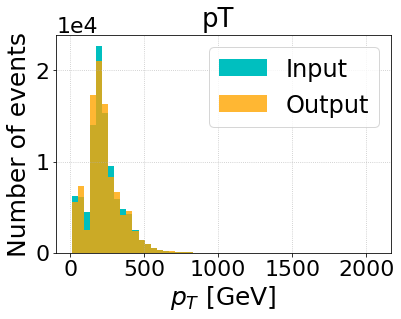

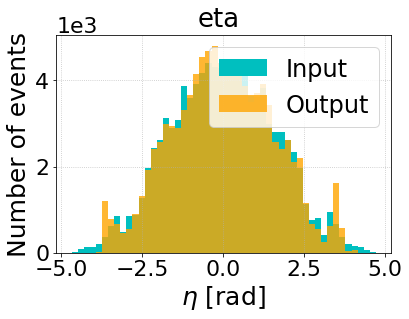

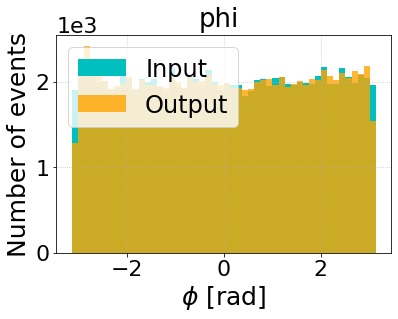

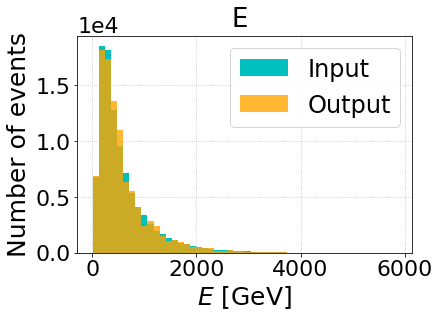

In [24]:
plt.close('all')
unit_list = ['[GeV]', '[rad]', '[rad]', '[GeV]']
variable_list = [r'$p_T$', r'$\eta$', r'$\phi$', r'$E$']
line_style = ['--', '-']
colors = ['orange', 'c']
markers = ['*', 's']


# Histograms
idxs = (0, 100000)  # Choose events to compare
data = torch.tensor(test_x[idxs[0]:idxs[1]].values)
pred = model(data).detach().numpy()
pred = np.multiply(pred, train_std.values)
pred = np.add(pred, train_mean.values)
data = np.multiply(data, train_std.values)
data = np.add(data, train_mean.values)

alph = 0.8
n_bins = 50
for kk in np.arange(4):
    plt.figure(kk + 4)
    n_hist_data, bin_edges, _ = plt.hist(data[:, kk], color=colors[1], label='Input', alpha=1, bins=n_bins)
    n_hist_pred, _, _ = plt.hist(pred[:, kk], color=colors[0], label='Output', alpha=alph, bins=bin_edges)
    plt.suptitle(train.columns[kk])
    plt.xlabel(variable_list[kk] + ' ' + unit_list[kk])
    plt.ylabel('Number of events')
    plt.legend()
    ms.sciy()

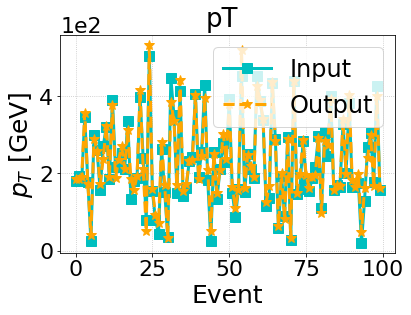

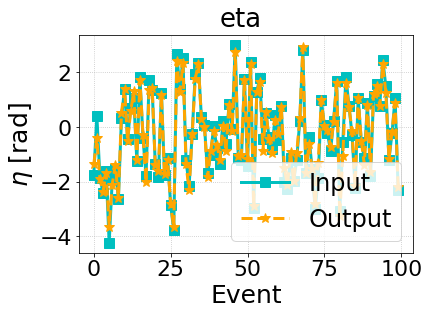

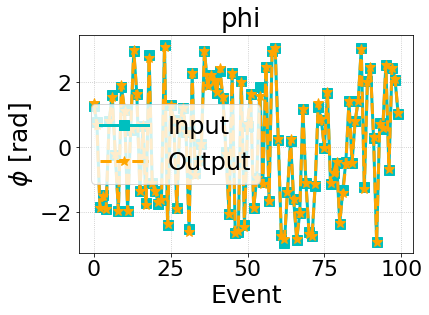

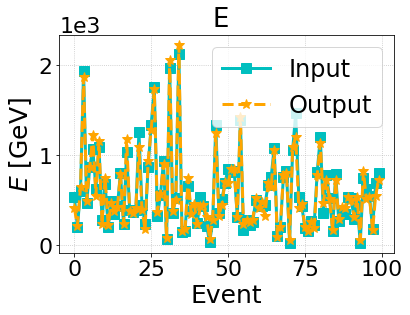

In [15]:
# Plot input on top of output
idxs = (0, 100)  # Choose events to compare
data = torch.tensor(test_x[idxs[0]:idxs[1]].values)
pred = model(data).detach().numpy()
pred = np.multiply(pred, train_std.values)
pred = np.add(pred, train_mean.values)
data = np.multiply(data, train_std.values)
data = np.add(data, train_mean.values)

for kk in np.arange(4):
    plt.figure(kk)
    plt.plot(data[:, kk], color=colors[1], label='Input', linestyle=line_style[1], marker=markers[1])
    plt.plot(pred[:, kk], color=colors[0], label='Output', linestyle=line_style[0], marker=markers[0])
    plt.suptitle(train.columns[kk])
    plt.xlabel('Event')
    plt.ylabel(variable_list[kk] + ' ' + unit_list[kk])
    plt.legend()
    ms.sciy()

In [16]:
# Plot input on top of output
idxs = (0, int(1e5))  # Choose events to compare
data = torch.tensor(test_x[idxs[0]:idxs[1]].values)
latent = model.encode(data).detach().numpy()

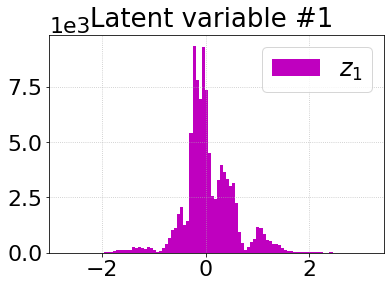

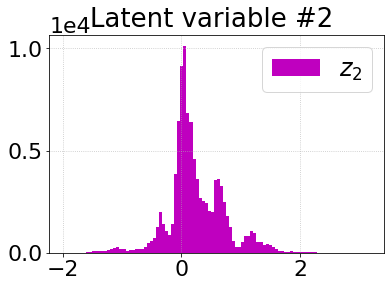

In [22]:
for ii in np.arange(latent.shape[1]):
    plt.figure()
    plt.hist(latent[:, ii], label='$z_%d$' % (ii + 1), color='m', bins=100)
    plt.suptitle('Latent variable #%d' % (ii + 1))
    plt.legend()
    ms.sciy()

Text(0, 0.5, '$z_2$')

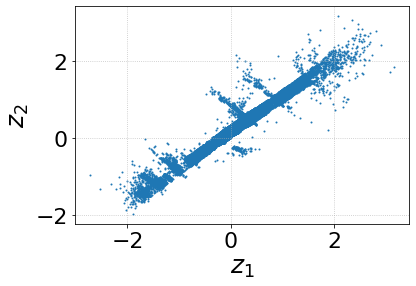

In [23]:
mksz = 1

plt.figure()
plt.scatter(latent[:, 0], latent[:, 1], s=mksz)
plt.xlabel(r'$z_1$')
plt.ylabel(r'$z_2$')